# Dog Breeds

Create a model to enter the [Dog Breeds competition at Kaggle](https://www.kaggle.com/c/dog-breed-identification):

*In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.*

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.transforms import tfms_from_model 
from fastai.dataset import get_cv_idxs
#from fastai.conv_learner import *
from pathlib import Path
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
torch.__version__

'0.4.0'

In [3]:
DOGS_PATH=Path('/data/dogsbreeds/')

In [4]:
PATH = "/data/dogsbreeds/"

# Data Exploration 

## Initial exploration, create validation set.

In [5]:
import os
print(os.listdir(PATH))

['models', 'tmp', 'sample_submission-2.csv', 'subm', 'test2', '.Sources', '__MACOSX', 'labels.csv', 'shelter', 'train', 'test']


`labels.csv` is the (downloaded from Kaggle) source file with all the ids and labels.
There is no 'valid' directory, only train and test. So we need to create our own valid directory.
`get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42)` :
Get a random list of index values for Validation set from a dataset

In [6]:
label_csv = f'{PATH}labels.csv'    # the source file with the labeled samples from Kaggle
n = len(list(open(label_csv))) - 1 # number of labels, - 1 for the header
val_idxs = get_cv_idxs(n, val_pct=0.21) # 0.2 is default

In [7]:
testfn = len(os.listdir(PATH+'test'))
trainfn = len(os.listdir(PATH+'train'))
cvfn = len(val_idxs)
print("Number of images.  Training:",trainfn, "Validation:", cvfn, "Test:", testfn)

Number of images.  Training: 10222 Validation: 2146 Test: 10357


## Get the labels into a dataframe to Analyze data Frequency

In [8]:
import pandas as pd
label_df = pd.read_csv(label_csv)  # use pandas to get a label data frame
label_df.head(3)  # take a look at it

id        breed
0  000bec180eb18c7604dcecc8fe0dba07  boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97        dingo
2  001cdf01b096e06d78e9e5112d419397     pekinese

Notice that the `id` column is not a file name, as it is missing the suffix .jpg

In [9]:
label_df.describe()
#Generates descriptive statistics that summarize the central tendency, 
#dispersion and shape of a dataset’s distribution, excluding NaN values.

id               breed
count                              10222               10222
unique                             10222                 120
top     549b9df75ad46e33bddfae7628609319  scottish_deerhound
freq                                   1                 126

In [10]:
from pandas_summary import DataFrameSummary
DataFrameSummary(label_df).summary()

id               breed
count                                    10222               10222
unique                                   10222                 120
top           549b9df75ad46e33bddfae7628609319  scottish_deerhound
freq                                         1                 126
counts                                   10222               10222
uniques                                  10222                 120
missing                                      0                   0
missing_perc                                0%                  0%
types                                   unique         categorical

So we have 10222 labels, matching the number of train images.
And we have 120 unique breeds. The top breed, (scottish_deerhound), has 126 images

In [11]:
v = label_df.apply(pd.Series.value_counts)['breed']
print("Number of labeled images per breed: Min=%d, Max=%d, mean=%d" % (v.min(), v.max(), v.mean()))

Number of labeled images per breed: Min=66, Max=126, mean=85


How do we deal with unbalanced dataset? 
This dataset has between 66 and 126 so it is a bit unbalanced, but not so much (per JH). 
Question: What is a good metric for "balanced"?  A recent paper suggests to deal with very unbalanced dataset by making copies of the rare cases.  
TBD: Try to make copies of the rare cases to see how it affects?
Another paper [Training Deep Neural Networks on Imbalanced Data Sets](https://pdfs.semanticscholar.org/a0d8/6c44f2843a483dfffbfc03dda230bbaad4cc.pdf) suggests
a novel loss function called `mean squared false error` is proposed for the training of
deep networks on imbalanced data sets to effectively capture classification errors from both majority
class and minority class equally. 

In [12]:
# create sorted pivot table to see how many images of each breed
freqbreed = label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False) 
freqbreed.rename(columns={'id':'cnt'}, inplace=True)
freqbreed.head(5)

cnt
breed                    
scottish_deerhound    126
maltese_dog           117
afghan_hound          116
entlebucher           115
bernese_mountain_dog  114

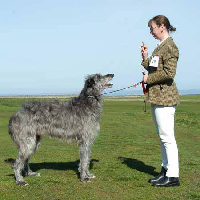

In [13]:
##### Most frequent dog sample
scottish_deerhound_id = label_df.loc[label_df.breed == "scottish_deerhound"].iloc[1, 0]
Image.open(PATH+"/train/"+scottish_deerhound_id+".jpg").resize((200,200))

In [14]:
freqbreed.tail(5)

cnt
breed                 
golden_retriever    67
brabancon_griffon   67
komondor            67
briard              66
eskimo_dog          66

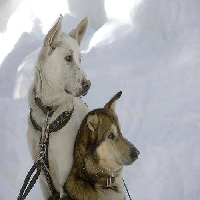

In [15]:
#Least ferquent dog sample
eskimo_dog_id = label_df.loc[label_df.breed == "eskimo_dog"].iloc[4, 0] #0 row is too agressive, so i decided to take 1st :)
Image.open(PATH+"/train/"+eskimo_dog_id+".jpg").resize((200,200))

In [16]:
def plotdogs(ims, figsize=(14,7), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [17]:
#Lets take a look at the most/least frequent dogs
def show_dogs(doglist, title):
    titles = []
    imgst = []
    n = 5 
    for b in  doglist :    #freqbreed.head(5).index: #, freqbreed.tail(5).index:
        dog_id = label_df.loc[label_df.breed == b].iloc[0, 0]
        #print(dog_id, b) #, freqbreed[b].breed)
        ffn = PATH+"train/"+dog_id+".jpg"
        imgst.append(Image.open(ffn).resize((200,200))) 
        titles.append(b) 
    print(title)
    plotdogs(imgst,titles=titles) #, rows=n//5,figsize=(50,50))

In [ ]:
show_dogs(freqbreed.head(5).index, "Top Frequent Dogs")

Top Frequent Dogs


In [ ]:
show_dogs(freqbreed.tail(5).index, "Least Frequent Dogs")

`breed_freq` given a breed, returns the current frequency.
TODO: use it to create a more balanced training set...

In [ ]:
def breed_freq (dog_breed):
    p = freqbreed[freqbreed.index == dog_breed].cnt
    return int(p)

In [ ]:
breed_freq("golden_retriever")

# Steps to Train the classifier

1. Enable data augmentation, and precompute=True
2. Use `lr_find()` to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use `lr_find()` again
8. Train full network with cycle_mult=2 until over-fitting

## Enable Data Augmentation

**How does the batch size affect training?** If we show less images (smaller batchsize), then it is calculating the gradient with less images — hence less accurate. In other words, knowing which direction to go and how far to go in that direction is less accurate. So as you make the batch size smaller, you are making it more volatile. It impacts the optimal learning rate that you would need to use, but in practice, dividing the batch size by 2 vs. 4 does not seem to change things very much. If you change the batch size by much, you can re-run learning rate finder to check.

In [ ]:
from fastai.torch_imports import resnext101_64, resnext50, resnet34
sz=224  # default image size
#arch=resnext101_64  #use resnext model
#arch=resnet34; bs=100
arch=resnext50; bs=40
#bs=80 #56 # batch size

`max_zoom` — zoom in up to 1.1 times

In [ ]:
from fastai.dataset import tfms_from_model, ImageClassifierData, FilesIndexArrayDataset
from fastai.transforms import transforms_side_on

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

`ImageClassifierData.from_csv` previously we used from_paths. Now labels are in CSV file.<br>
Arguments:
* path: a root path of the data (used for storing trained models, precomputed values, etc)
* trn: a tuple of training data matrix and target label/classification array (e.g. `trn=(x,y)` where `x` has the
                shape of `(5000, 784)` and `y` has the shape of `(5000,)`)
* val: a **tuple** of validation data matrix and target label/classification array.
* bs: batch size
* tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
* classes: a list of all labels/classifications
* num_workers: a number of workers
*  test: a matrix of test data (the shape should match `trn[0]`)

In [ ]:
#Now from csv (previously was from paths)
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', 
                                    val_idxs=val_idxs, 
                                    suffix='.jpg', tfms=tfms, bs=bs)

In [ ]:
#How many classes and which are the first 5
len(data.classes), data.classes[:5]

Access to training dataset by `data.trn_ds`, which contains a lot of things including file names (`.fnames`)

In [ ]:
label_df.head(2)

In [ ]:
# select a random image example from the training set
import random, PIL
ri = random.randint(1, trainfn-cvfn)
fn = data.trn_ds.fnames[ri]
fnn = PATH+data.trn_ds.fnames[ri];  
fnid = fn[6:-4]  # extract id from name
p = label_df[label_df.id==fnid].breed
b = str(p.values[0])
print("Id:", fnid, "Breed:", b, "Frequency:", breed_freq(b)) #, data.classes[data.val_y[ri]])
img = PIL.Image.open(fnn); img

###  Evaluate the image sizes 

- `img.size` how big is this image?
- `data.trn_ds.fnames` has all the names of the files in the training set.
- `PIL.Image.open(fp, mode='r')` Opens and identifies the given image file.
- `size_d` will be a dictionary (build as a comprehension, where k takes all the file names and becomes the key of the dictionary) of all the sizes of the training files.

- `(*size_d.values)` will unpack a list. 
- zip will pair up elements of tuples to create a list of tuples.

In [ ]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}   
row_sz, col_sz = list(zip(*size_d.values()))  # pull all the sizes from the dictionary for each file
row_sz= np.array(row_sz); col_sz=np.array(col_sz)  #convert to np arrays

In [ ]:
#row_sz[:6], col_sz[:6]  #take a look at the sizes of the first 6 images

In [ ]:
#plt.hist(row_sz); plt.hist(col_sz);  #histogram of all values

In [ ]:
#plt.hist(row_sz[row_sz<1000]); #Histogram of all rows below 1000

In [ ]:
#plt.hist(col_sz[col_sz<1000]); #histogram of columns < 1000

## Find Learning Rate

In [ ]:
from fastai.conv_learner import ConvLearner

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5) # what is the right .ps ?
#EX:12/9 dropout to 0 here to see how it affects learning rte
#Bigger network may require bigger dropout?
%time learn.lr_find()  

In [ ]:
learn.sched.plot_lr() # plot of iterations?? versus learning rate

In [ ]:
learn.sched.plot(n_skip=30)  # plot of loss versus learning rate, skip the first 30 iterations

The loss is still clearly improving at lr=10e-2 (0.01), so that's what we use. Recall that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

# Initial Model

To expedite things we want to do things with smaller images. JH usually starts with images of size 64 for fastest.
Later when he uses larger images, we need to use this to reduce the use of GPU RAM.
`get_data` gets the size and batchsize. 
It creates the `data` object using the usual transformation and classifier. 
It returns the data object if its size is > 300, else resize it to 340.

JH: *Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time.*
If sz > 300 we use it as it is in ‘train’, ‘valid’, ‘test’ folder.
and if the image size is less than 300, we resize it into 340 size and place it in /tmp folder. 


In [ ]:
def get_data(sz,bs, val_idxs=val_idxs):  # sz=size, bs=batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val_idxs, 
                                        suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

##  Pre-compute

In [ ]:
# Uncomment to reset the precomputed activations
#!rm -rf {PATH}tmp

In [ ]:
data = get_data(sz, bs)

With precompute=True, data augmentation does not do anything because we are showing exactly the same activations each time.

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5) 

## Train last layer from precomputed activations for 1-2 epochs

In [ ]:
lr = 1e-2

In [ ]:
%time learn.fit(lr, 6)

Results look good, so we turn precompute to False

## Train last layer with data augmentation 
(i.e. precompute=False) for 2-3 epochs with cycle_len=1.
This enables stochastic gradient descent with restarts (SGDR), ie **learning rate annealing**. As it gets closer to the minimal loss, start decreasing the learning rate ($\mu$) (taking smaller steps) to get to the right spot.

In [ ]:
learn.precompute=False

In [45]:
%time learn.fit(lr, 6, cycle_len=1)  #cycle_len=1 is equal to epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.32296    0.298725   0.904473  
    1      0.312095   0.303351   0.906803                    
    2      0.305623   0.298714   0.907269                    
    3      0.290943   0.299836   0.906803                    
    4      0.308955   0.298188   0.908201                    
    5      0.262858   0.295232   0.909133                    

CPU times: user 12min 43s, sys: 1min 8s, total: 13min 52s
Wall time: 4min 3s


[0.29523154871689306, 0.9091332693135528]

This is **under**-fitting, as val_loss < trn_loss, so let increase the cycle_len.  If under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly). So we will add `cycle_mult=2` (i.e. 1st cycle is 1 epoch, 2nd cycle is 2 epochs, and 3rd cycle is 4 epochs)

In [46]:
%time learn.fit(lr, 4, cycle_len=2) 

epoch      trn_loss   val_loss   accuracy                    
    0      0.301653   0.296733   0.908201  
    1      0.248668   0.295497   0.904473                    
    2      0.242783   0.304542   0.905405                    
    3      0.235159   0.305573   0.907269                    
    4      0.232403   0.311513   0.904007                    
    5      0.197963   0.305885   0.903075                    
    6      0.224973   0.320761   0.901212                    
    7      0.209433   0.314008   0.901212                    

CPU times: user 16min 55s, sys: 1min 29s, total: 18min 24s
Wall time: 5min 24s


[0.31400796718277446, 0.9012115553840786]

In [47]:
learn.save('224_pre')
learn.load('224_pre')

## Steps 5-7 RETRAIN the earlier layers, in this case it is useless since the images are from Imagenet
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again

## Increase size of images
**Cool trick to avoid overfitting**: run first on smaller images, and then grow the data size.
Here we continue to train with larger images...
Imagenet used 224 and 299 sized images..?

In [48]:
#bs=90
learn.set_data(get_data(339, bs)) #299,bs))
learn.freeze()

In [49]:
%time learn.fit(1e-2, 6, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.268538   0.274755   0.907269  
    1      0.250628   0.263969   0.911463                    
    2      0.242933   0.261835   0.914725                    
    3      0.232537   0.259288   0.918453                    
    4      0.234114   0.268967   0.914259                    
    5      0.2122     0.264565   0.919385                    

CPU times: user 24min 45s, sys: 2min 55s, total: 27min 41s
Wall time: 9min 5s


[0.2645653752403513, 0.9193849038100087]

In [50]:
learn.save('339_pre')
learn.load('339_pre')

If it was **under**-fitting, then lets increase the cycle_len.  If under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly). So we will add `cycle_mult=2` (i.e. 1st cycle is 1 epoch, 2nd cycle is 2 epochs, and 3rd cycle is 4 epochs)
(But above is usually not underfitting...) 

In [51]:
%time learn.fit(lr, 4, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.214087   0.269345   0.917521  
    1      0.200506   0.265826   0.917521                    
    2      0.195386   0.265964   0.917055                    
    3      0.178157   0.265796   0.919385                    
    4      0.18828    0.26258    0.921249                    
    5      0.16174    0.262229   0.916589                    
    6      0.188819   0.268045   0.918453                    
    7      0.159336   0.264595   0.919851                    

CPU times: user 32min 58s, sys: 4min 7s, total: 37min 5s
Wall time: 12min 27s


[0.26459504784070104, 0.9198508854792258]

When the validation loss and training loss are about the same — this is the right track.
So lets try data augmentation with TTA.

In [52]:
log_preds,y = learn.TTA()

In [53]:
from sklearn import metrics
from fastai.metrics import accuracy_np

In [54]:
probs = np.mean(np.exp(log_preds),0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

(0.2582593052831991, 0.9203168685927307)

Other things to try:
- Try running one more cycle of 2 epochs
- Unfreezing (in this case, training convolutional layers did not help in the slightest since the images actually came from ImageNet)
- Remove validation set and just re-run the same steps, and submit that — which lets us use 100% of the data.

In [55]:
#one more time...
%time learn.fit(lr, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.188589   0.264247   0.919385  
    1      0.16071    0.262797   0.920783                    

CPU times: user 8min 11s, sys: 1min 4s, total: 9min 16s
Wall time: 3min 10s


[0.262796964701213, 0.9207828487621105]

In [56]:
#and again TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

(0.253006518899352, 0.924044734389562)

# Analyzing results on Validation Set:
looking at pictures

In [57]:
# this gives prediction (in log probabilities) for the validation set.  (WT=30s)
%time log_preds = learn.predict()
#log_preds.shape

CPU times: user 38.8 s, sys: 6.83 s, total: 45.6 s
Wall time: 19.5 s


In [58]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to the breed classes 0 to 119
probs = np.exp(log_preds)        # probability of each dog-breed

In [59]:
log_preds.shape, preds.shape, probs.shape, data.val_y.shape

((2146, 120), (2146,), (2146, 120), (2146,))

How many images we miss-classified in the validation set?

In [60]:
assert(len(preds) == len(data.val_y))

In [61]:
missed_breeds = [] # np.asarray(data.classes,0) #for i in range(120)
accurate_breeds = []
mislabeled_images = 0
for i in range(cvfn):
    if (preds[i] == data.val_y[i]):
        accurate_breeds.append(preds[i])
    else:
        missed_breeds.append(data.val_y[i])
        mislabeled_images +=1
                             
missed_dict = {data.classes[i]:missed_breeds.count(i) for i in missed_breeds}
accurate_dict = {data.classes[i]:accurate_breeds.count(i) for i in accurate_breeds}
print("Number of breeds that were mis-classified:", len(missed_dict)), 
print("Images missclassified:", mislabeled_images, "out of:", cvfn, "ratio:", mislabeled_images / cvfn) #; missed_dict

Number of breeds that were mis-classified: 75
Images missclassified: 170 out of: 2146 ratio: 0.07921714818266543


In [62]:
%matplotlib inline
#from sklearn.metrics import confusion_matrix
#from fastai.plots import plot_confusion_matrix
#too many classes to be able to see in a confusion matrix.
#cm = confusion_matrix(data.val_y, preds)
#plot_confusion_matrix(cm, data.classes, normalize=True, figsize=(200,200))

### Auxiliary definitions for plotting

In [63]:
def rand_by_mask(n, mask): return np.random.choice(np.where(mask)[0], n, replace=False)
def rand_by_correct(n, is_correct): return rand_by_mask(n, (preds == data.val_y)==is_correct)

In [64]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [65]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [data.classes[np.argmax(probs[x])] for x in idxs]
    title_label = [data.classes[data.val_y[x]] for x in idxs] # get the true label
    #titleP = "TrueLabel:" + str(title_label) + "\nPredicted:" + str(title_probs)
    print(title, "Expected:", title_label)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

`data.val_y` contains the labels for the classes for each of the validation set images.
`preds` has the predicted labels.

### Explore which were correctly classified and which were not

Correctly classified.
 Expected: ['italian_greyhound', 'schipperke', 'malinois', 'saluki', 'old_english_sheepdog']


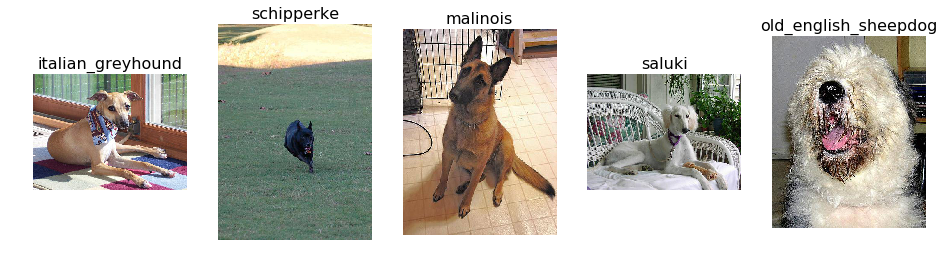

In [66]:
# 1. A few (e.g. 5) correct labels at random
plot_val_with_title(rand_by_correct(5, True), "Correctly classified.\n")

Incorrectly classified. Expected: ['schipperke', 'miniature_schnauzer', 'eskimo_dog', 'american_staffordshire_terrier', 'airedale']


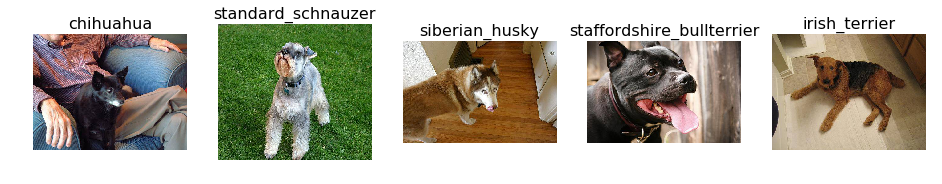

In [67]:
# 2. A few (e.g. 5) incorrect labels at random
plot_val_with_title(rand_by_correct(5, False), "Incorrectly classified.")

### Best and worst cases (TBD)
`most_by_correct` was designed for a binary classification. needs to be fixed.

In [68]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [69]:
#plot_val_with_title(most_by_correct(y ,True), "Most correct ")

In [70]:
#most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
#plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [71]:
from PIL import Image

In [72]:
def plot_most_confident(n=5, title=None, accurate=True, figsize=(40,30)):
    imgst = []
    titles = []

    maxp = np.zeros(cvfn)
    for i in range(cvfn): 
        eq = (preds[i] == data.val_y[i])
        if (accurate and eq):
            maxp[i] = max(probs[i])
        elif ((not accurate) and (not eq)):
            maxp[i] = max(probs[i])
    topnf = list(maxp.argsort()[-n:])
    smaxp = sorted(maxp)
    print(title, "Top prediction probs\n", smaxp[-n:])
    for f in topnf:
        fn = data.val_ds.fnames[f]
        ffn = f'{PATH}'+fn
        imgst.append(Image.open(ffn).resize((200,200))) 
        titles.append("Predicted:" + data.classes[preds[f]] + "\nTrue Label:" + data.classes[data.val_y[f]] ) 
    plots(imgst,titles=titles, rows=n//5,figsize=figsize)

Most Correct  Top prediction probs
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


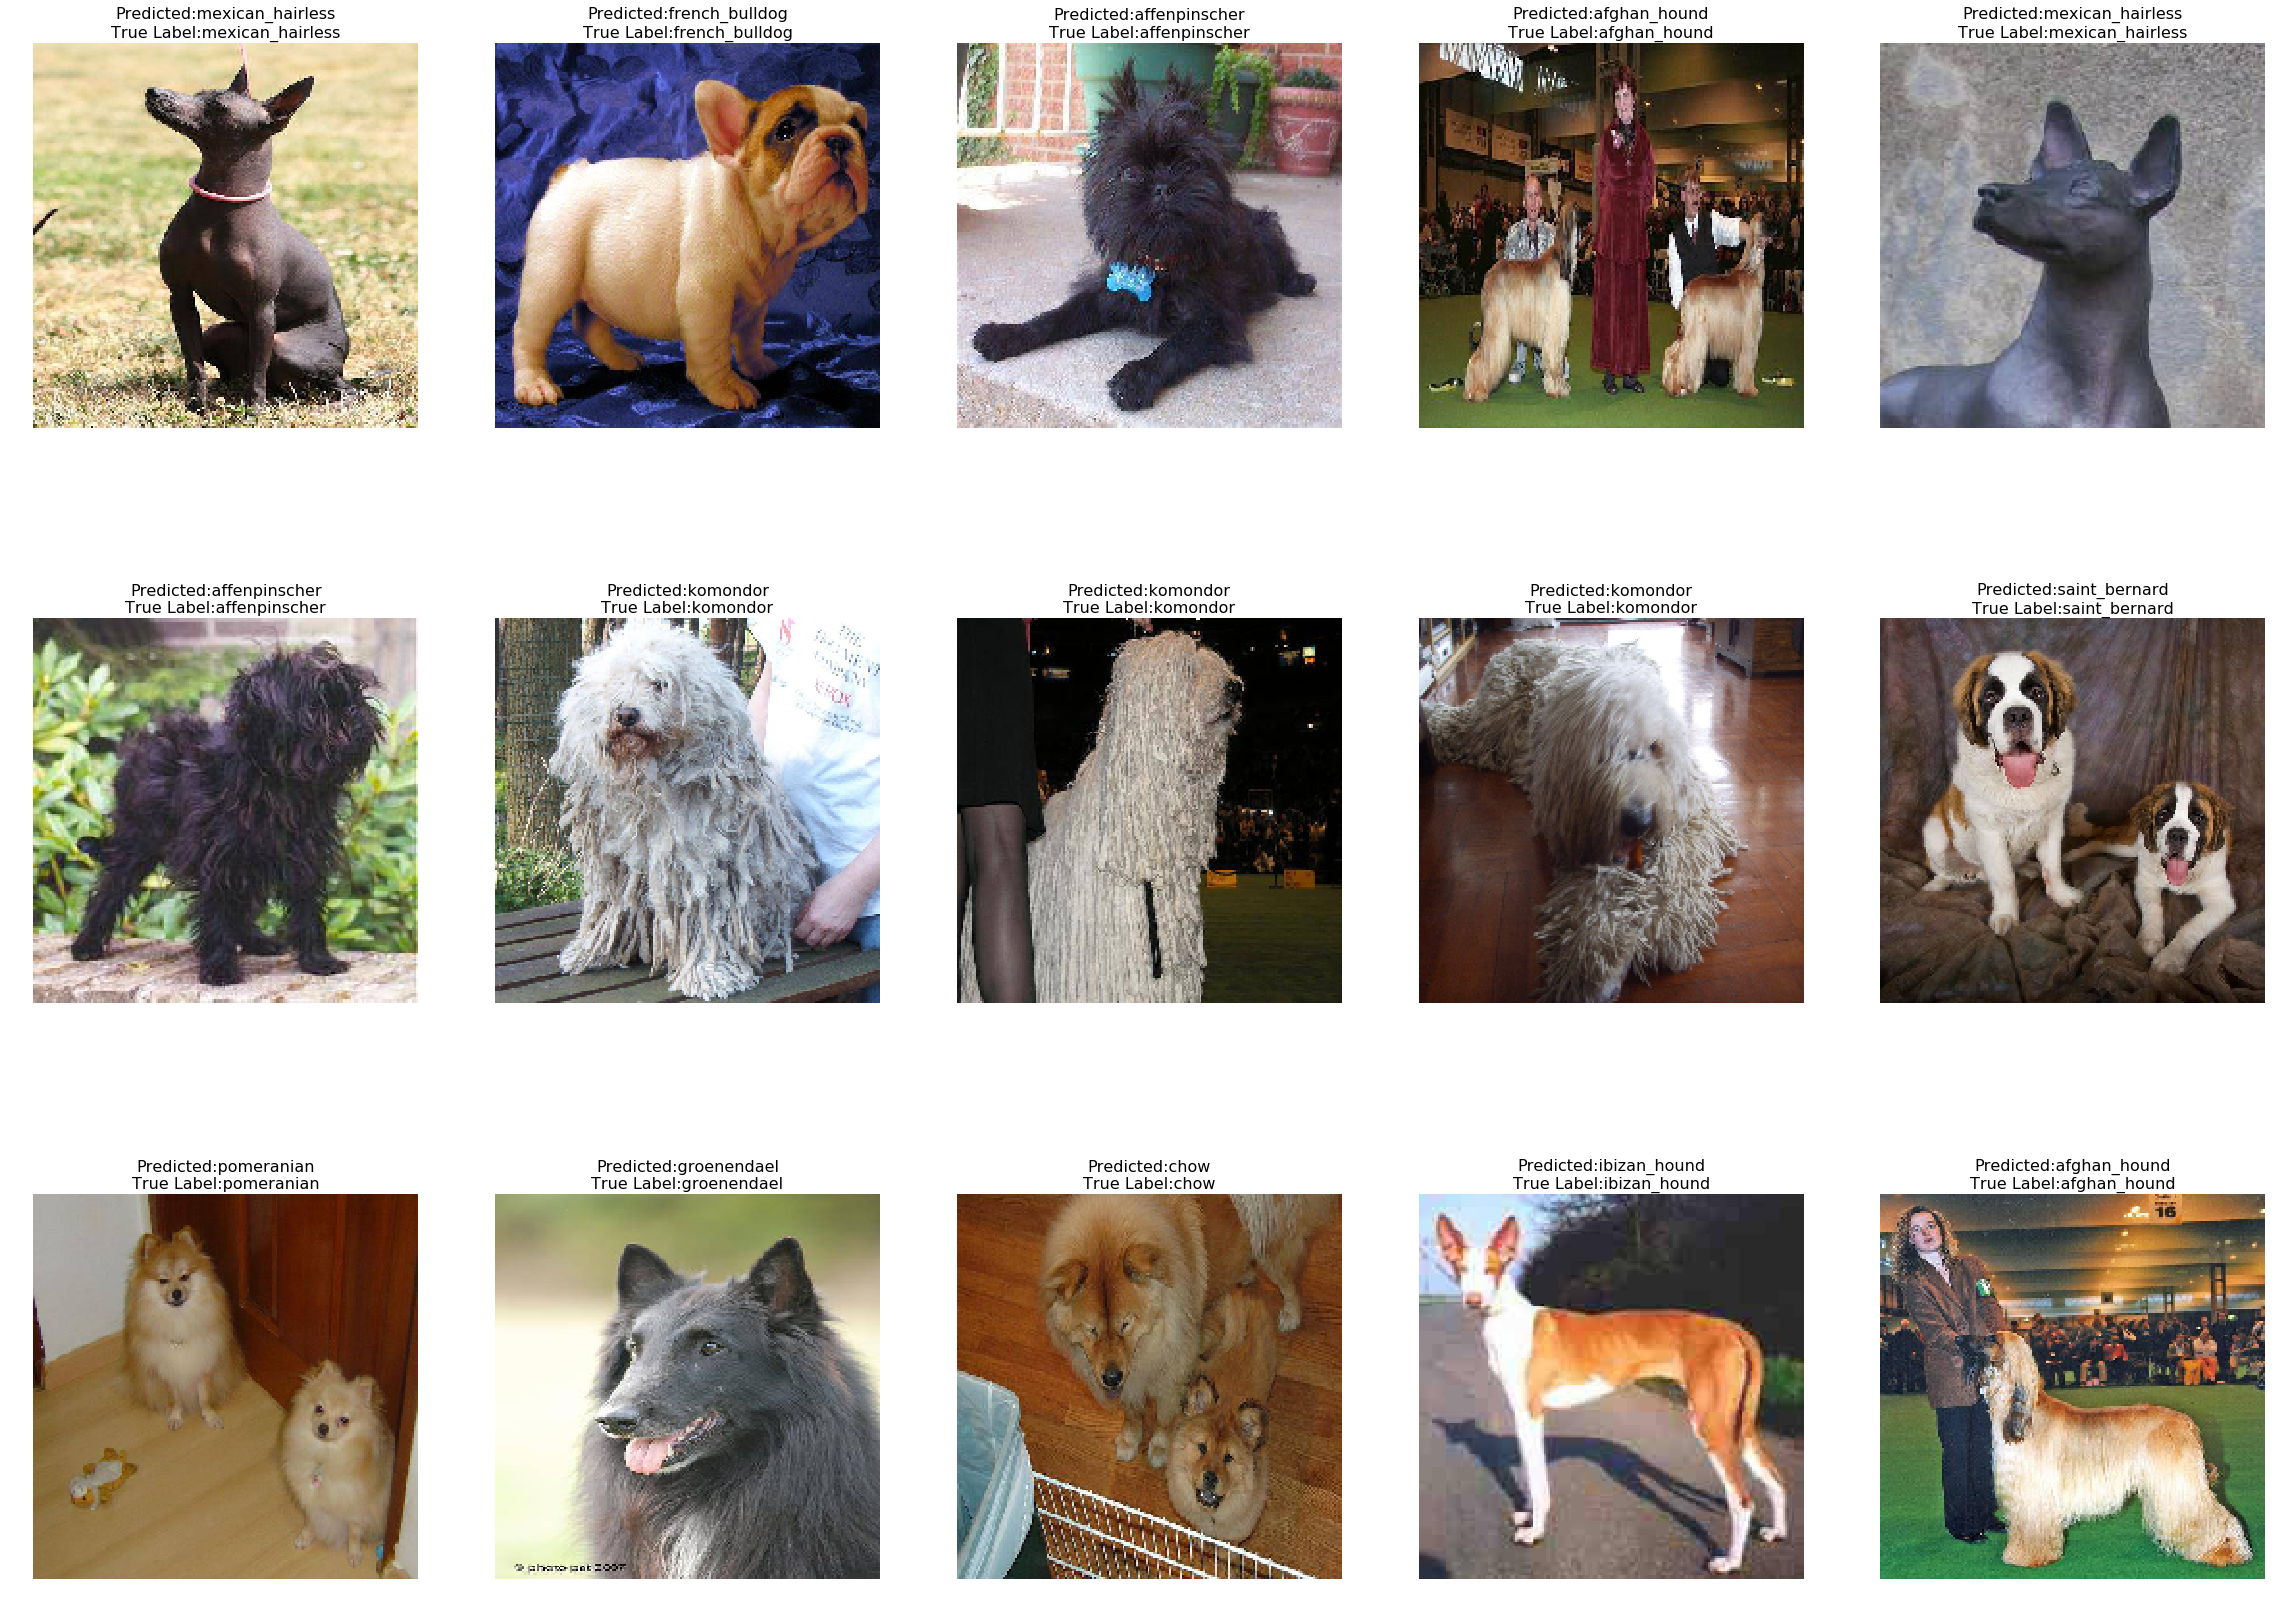

In [73]:
plot_most_confident(n=15, title="Most Correct ", accurate=True)

Most Wrong Top prediction probs
 [0.9644174575805664, 0.9678735733032227, 0.9730740189552307, 0.976924479007721, 0.9823862314224243, 0.9831641316413879, 0.9843340516090393, 0.9912872910499573, 0.9917080402374268, 0.994027853012085, 0.9940610527992249, 0.9946414232254028, 0.9973808526992798, 0.9978565573692322, 0.9992240071296692]


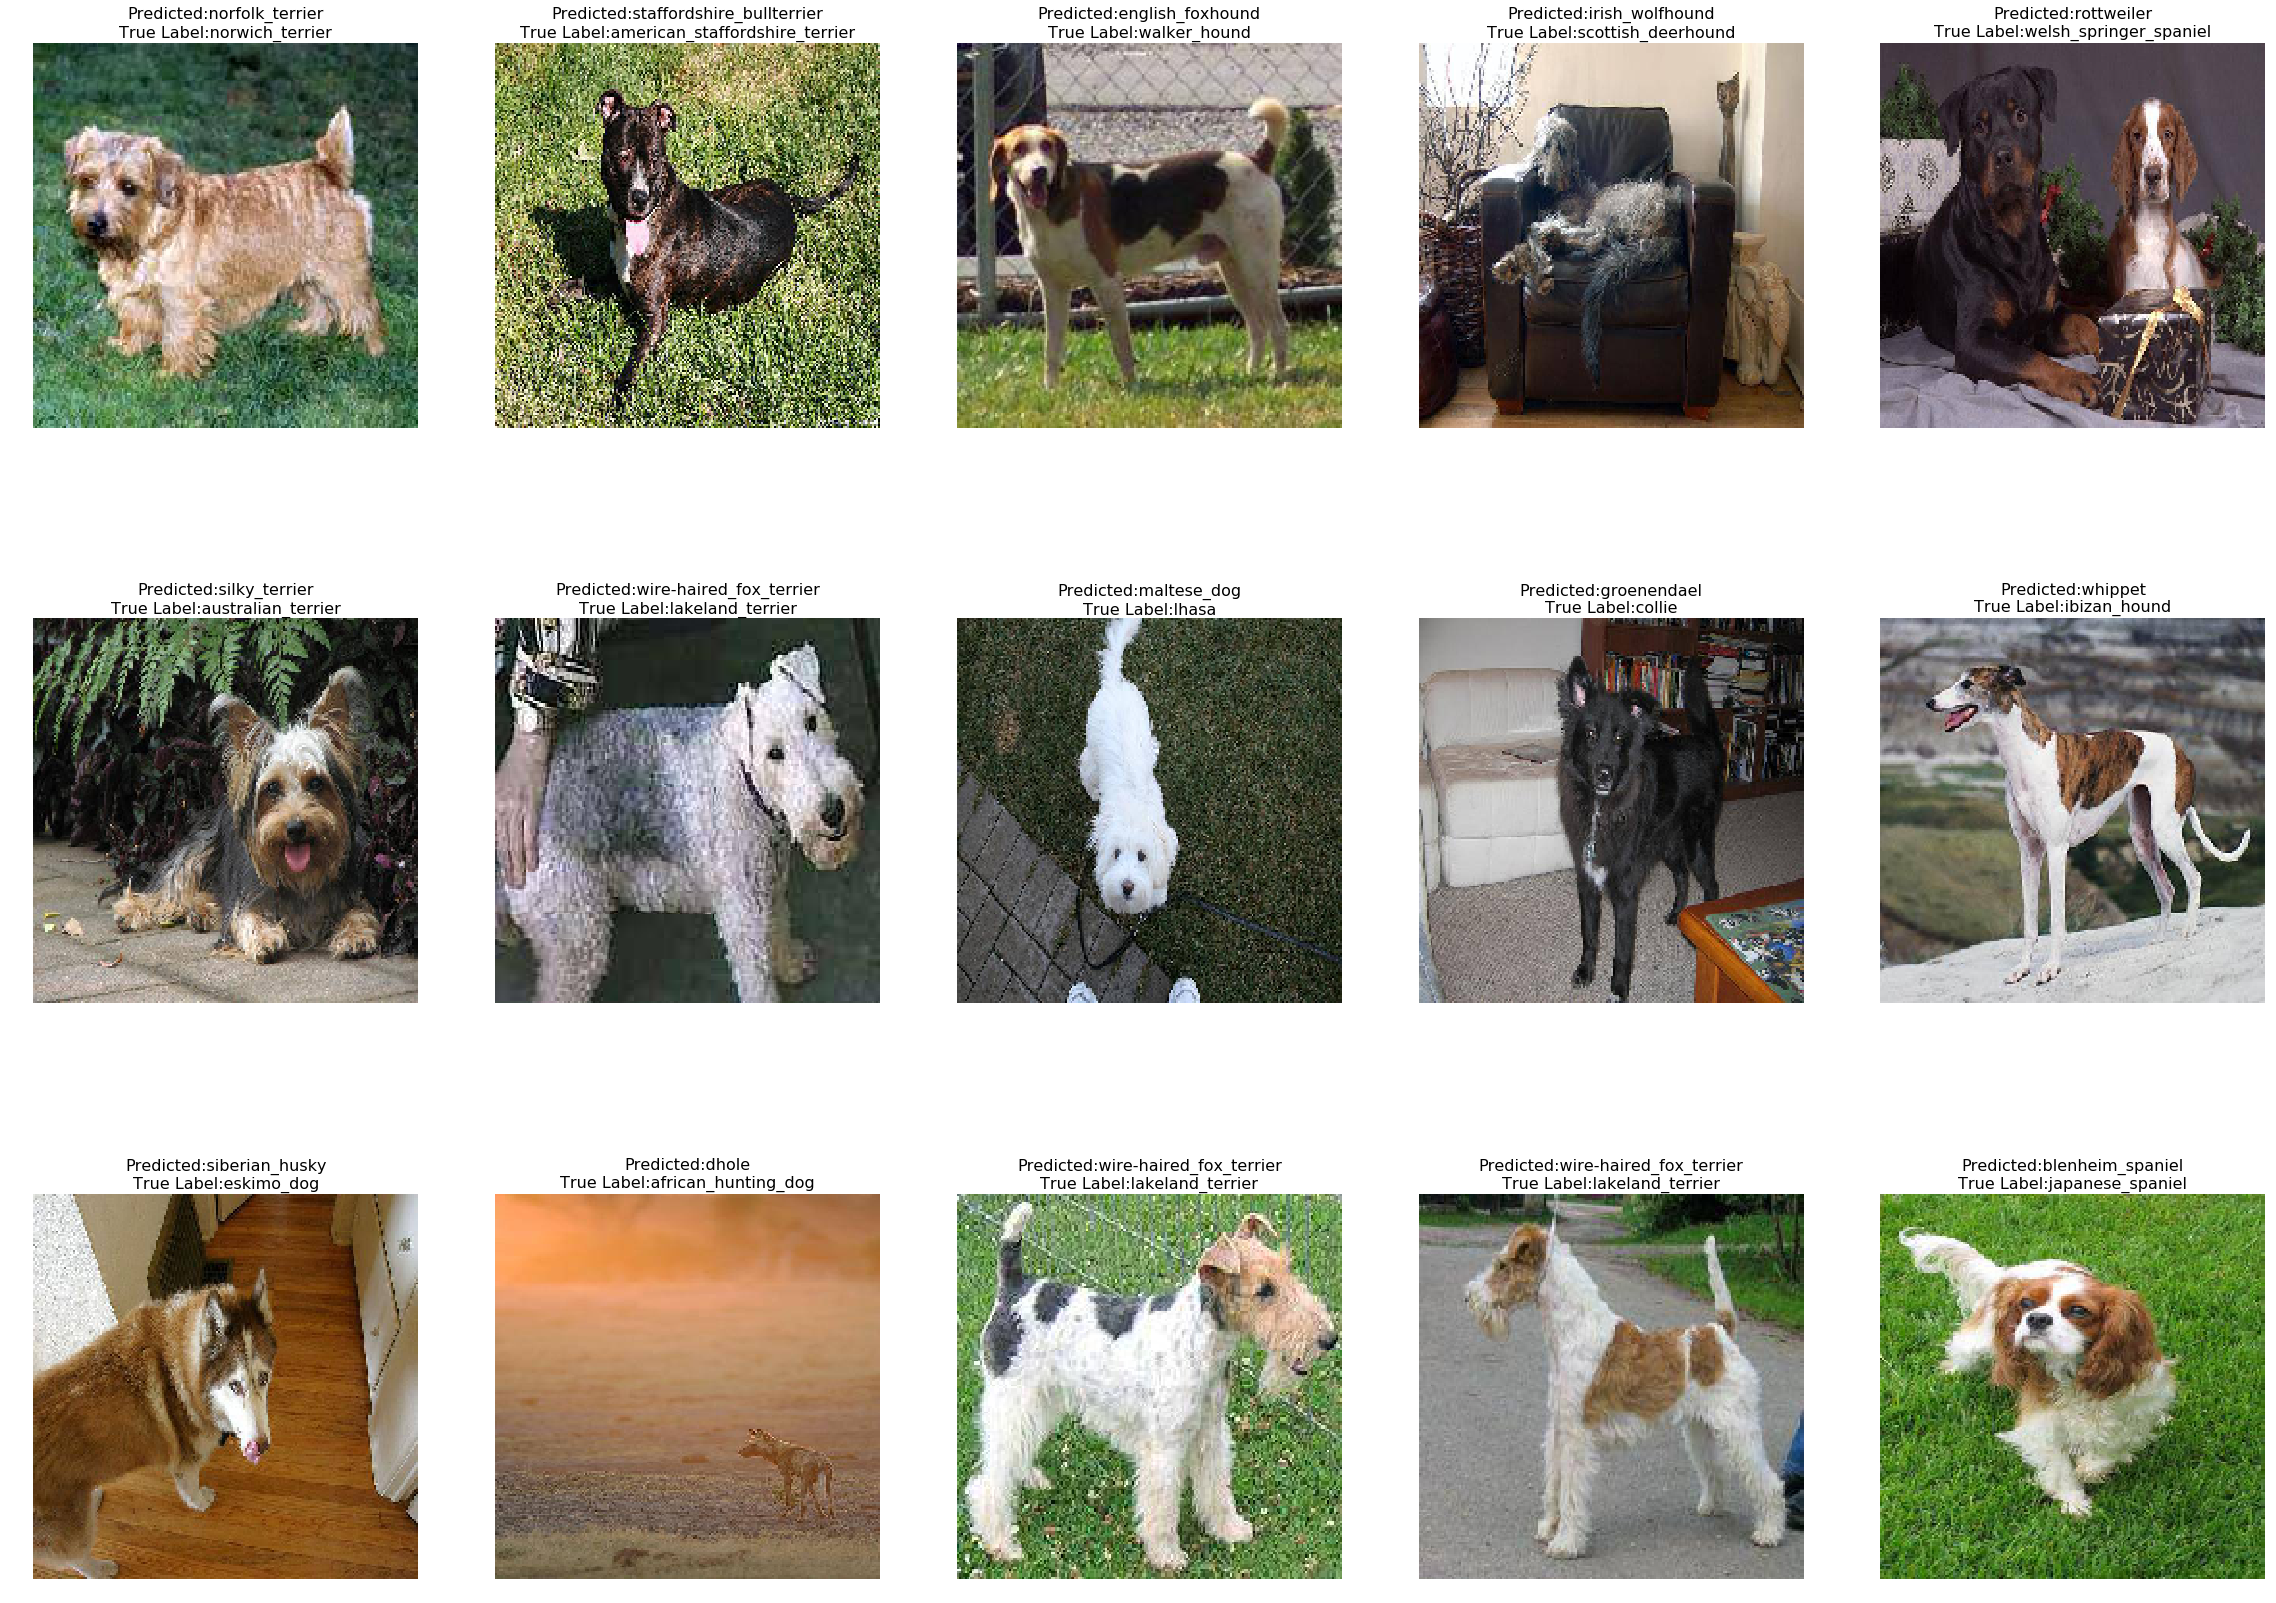

In [74]:
plot_most_confident(n=15, title="Most Wrong", accurate=False)

# Rerun on all data 
including the validation set, (i.e., `val_idxs=None`), so we use all available data to train.
Now we are training "blind" so we need to use the same parameters as before...
This work because we have already determined our model and process is good enough with a validation set first?

In [75]:
lsz= 339
learn.set_data(get_data(lsz, bs, val_idxs=None)) #299,bs))
learn.freeze()

In [76]:
%time learn.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.160589   0.272126   0.918297  
    1      0.170245   0.273642   0.918297                    
    2      0.171338   0.27355    0.915851                    
    3      0.156659   0.276531   0.911448                    

CPU times: user 16min 25s, sys: 2min 22s, total: 18min 48s
Wall time: 6min 34s


[0.27653090877425646, 0.9114481390339054]

# Augment Data at Inference (Test) Time

Data augmentation at *inference* time (aka *test* time), aka *Test Time Augmentation*, or just *TTA*.
TTA makes predictions on the images of the (default is validation) set, but also makes predictions on a number of randomly augmented versions of them (by default, it uses the original image along with 4 randomly augmented versions). 
`learn.TTA` when `is_test == True` makes predictions on the test set.
**NB:** the 2nd returned parameter (_) is all zeroes, (hence ignored), since by definition, there are no labels in the test set.  Below takes about xx minutes to run

In [77]:
%time log_preds,_ = learn.TTA(is_test=True)    

CPU times: user 20min 31s, sys: 3min 4s, total: 23min 35s
Wall time: 8min 14s


In [78]:
log_preds.shape, type(log_preds)

((5, 10357, 120), numpy.ndarray)

TTA returned a np array with 5 predictions (log probability) for every one of the 10357 source images, for every one of the 120 classes. 

We then take the average of the 5 predictions. 

`probs` has the probabilities of each of the breeds computed as the mean for the 5 images.
`preds` gets the (index number via argmax) of the class (breed) with the highest probability of the 120 classes as a prediction for each image.

In [79]:
probs = np.mean(np.exp(log_preds),0) 
preds = np.argmax(probs, axis=1)  

Obviously, we can't compute accuracy on the test set as they are unlabeled! :) 

JH: "about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!"

# Review some Test Results 
(prior to submission)

In [80]:
def plotstest(ims, figsize=(30,15), rows=6, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

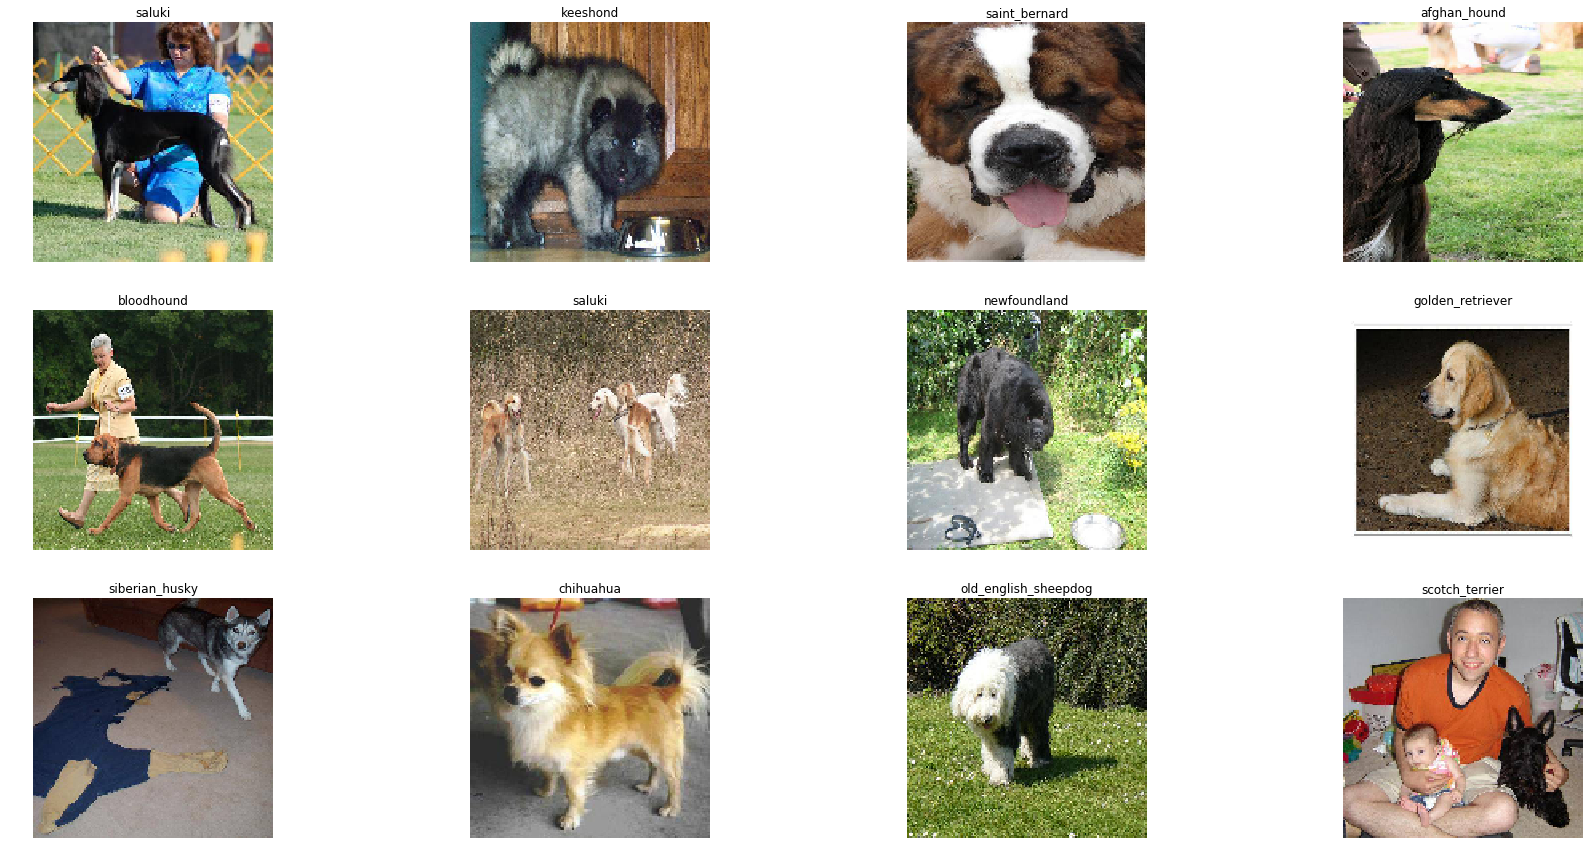

In [81]:
PATH2='/data/dogsbreeds/'
imgs=[]; titles=[]
rows=3
for i in range(4*rows): #must be multiple of rows
    fn = data.test_ds.fnames[i]
    fullfname = f'{PATH2}'+fn   #full name   #print(fn[10:-4])
    imgs.append(Image.open(fullfname).resize((150,150))) #add it to the imgs list 
    titles.append(data.classes[np.argmax(probs[i])])     #Breed as title
plotstest(imgs,titles=titles, rows=rows)

# Create Submission

**File Format from Kaggle:**

id,affenpinscher,afghan_hound,african_hunting_dog,airedale,...., yorkshire_terrier 
000621fb3cbb32d8935728e48679680e,0.00833333333333333,0.00833333333333333,0.00833333333333333, ....

to avoid the first 5 chars "test/" and the 4 last chars of the filenames, we use `[5:-4]`

In [82]:
df = pd.DataFrame(probs)   # Create a dataframe of the probabilities
df.columns = data.classes  # label the columns as the breeds (the classes)
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames]) #the short names of the files
#df.head()

In [83]:
PATH2='../data2/dogsbreeds/'
SUBMDIR = f'{PATH2}subm/'  # submission directory
os.makedirs(SUBMDIR, exist_ok=True)
import time
SUBMF = SUBMDIR+"Kaggle"+time.strftime("%Y%m%d-%H%M%S")+'.gz'
df.to_csv(SUBMF, compression='gzip', index=False)

In [84]:
from IPython.lib.display import FileLink
FileLink(SUBMF)  # to download via URL

/home/german/DeepLearning/data2/dogsbreeds/subm/Kaggle20180715-201849.gz

# Individual Prediction (TBC)

We want to run a single image through a model to get a prediction?
Below we randomly choose one from the test set.
 Image must be transformed. `tfms_from_model` returns training transforms and validation transforms. In this case, we will use validation transform.
Everything that gets passed to or returned from a model is generally assumed to be in a mini-batch. Here we only have one image, but we have to turn that into a mini-batch of a single image. In other words, we need to create a tensor that is not just [rows, columns, channels] , but [number of images, rows, columns, channels].
im[None] : Numpy trick to add additional unit axis to the start.

In [85]:
TESTDIR = f'{PATH}test/'
import random
from PIL import Image
trn_tfms, val_tfms = tfms_from_model(arch, sz)

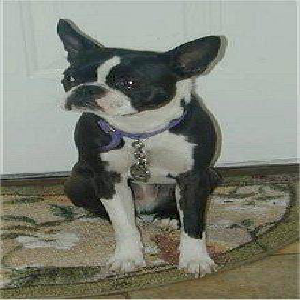

In [86]:
# random.choice selects random element
# os.listdir lists in current directory
filename = random.choice(os.listdir(TESTDIR))
ffn = TESTDIR+filename
img1 = Image.open(ffn).resize((300,300))
img1

In [87]:
from fastai.dataloader import DataLoader

In [88]:
ds = FilesIndexArrayDataset([filename], np.array([0]), val_tfms, TESTDIR) #PATH)
dl = DataLoader(ds)
individual_pred = learn.predict_dl(dl)   # It appends the /test directory
data.classes[np.argmax(individual_pred)]

'boston_bull'

# Save the predictions for evaluation

In [89]:
PATH2='/data/dogsbreeds/'
SAVEPREDS = f'{PATH}subm/savepreds'
f2 = open(SAVEPREDS, 'a')
for i in range(len(data.test_ds.fnames)): 
    fns = data.test_ds.fnames[i]
    fullfname = f'{PATH2}'+fns   #full name   #print(fn[10:-4])
    fns_pred = data.classes[np.argmax(probs[i])]     #Breed as title
    mprint = fns[5:-4] + ', ' + fns_pred +'\n'
    f2.write(mprint)
f2.close()

# Shelter predictions

In [91]:
#get the shelter images (independent test)
PATH2 = "/data/dogsbreeds/shelter/"
files = !ls {PATH2} #| head
SAVEshelter = f'{PATH}subm/shelterpreds'
f2 = open(SAVEshelter, 'w')
trn_tfms, val_tfms = tfms_from_model(arch, sz)
for f in files: 
    ds = FilesIndexArrayDataset([f], np.array([0]), val_tfms, PATH2)
    dl = torch.utils.data.DataLoader(ds)
    preds = learn.predict_dl(dl)
    mprint = f[0:-12] + ',' + data.classes[np.argmax(preds)] + '\n'
    f2.write(mprint)
f2.close()

# END